<h1>Placebo Treatment Refuter</h1>

In [2]:
%run 'HelperFunctions.ipynb'
%run 'Data Preprocessing.ipynb'

In [3]:
# Loading
loaded_normalized_models = load_estimators('//home/nissatech/Documents/Double Machine Learning/Models/NormalizedData/NormalizedModels.json')

In [4]:
scaler = StandardScaler()
df_energy_3_normalized = pd.DataFrame(scaler.fit_transform(df_energy_3), 
                                      columns=df_energy_3.columns, 
                                      index=df_energy_3.index)

df_env_3_normalized = pd.DataFrame(scaler.fit_transform(df_env_3), 
                                      columns=df_env_3.columns, 
                                      index=df_env_3.index)

In [5]:
data_df = df_energy_3_normalized.join(df_env_3_normalized['CO2'])

## Step 1: Building the model

In [39]:
# Importovanje neophodnih biblioteka
from dowhy import CausalModel
import pandas as pd

# Definisanje tretmana, ishoda i konfaundera
treatment = 'Current A average [A]'
outcome = 'CO2'
common_causes = ['Power Factor A average',
                 'Reactive Power A average [kVAr]',
                 'THDI A average [%]',
                 'THDU A average [%]',
                 'Voltage A average [V]']

# Kreiranje kauzalnog modela
causal_model = CausalModel(
    data=data_df,
    treatment=treatment,
    outcome=outcome,
    common_causes=common_causes
)

In [ ]:
causal_model.view_model(layout="dot")

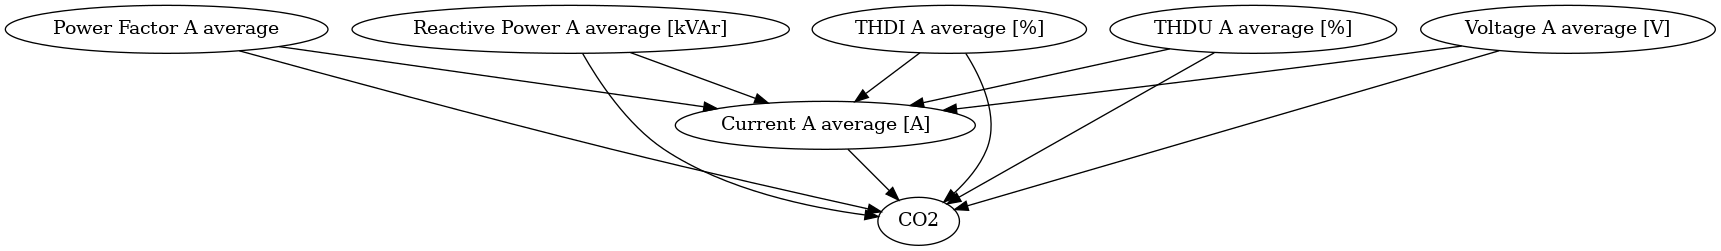

In [41]:
from IPython.display import Image
Image(filename="causal_model.png")

## Step 2: Identification

In [42]:
identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[CO2|Power Factor A average,THDI A average [%],THDU 
d[Current A average [A]]                                                      

                                                                     
A average [%],Reactive Power A average [kVAr],Voltage A average [V]])
                                                                     
Estimand assumption 1, Unconfoundedness: If U→{Current A average [A]} and U→CO2 then P(CO2|Current A average [A],Power Factor A average,THDI A average [%],THDU A average [%],Reactive Power A average [kVAr],Voltage A average [V],U) = P(CO2|Current A average [A],Power Factor A average,THDI A average [%],THDU A average [%],Reactive Power A average [kVAr],Voltage A average [V])

### Estimand : 2
Estimand name: iv
No such variable(s) found!

##

## Step 3: Estimation (using propensity score weighting)

In [43]:
estimate = causal_model.estimate_effect(
                    identified_estimand,
                    method_name="backdoor.linear_regression"
                )

print("The Causal Estimate is " + str(estimate.value))

The Causal Estimate is 1.1780999774699867


In [44]:
# Estimation using EconML


In [45]:
#TODO: uključiti EconML DoubleML

In [46]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = causal_model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':RandomForestRegressor(),
                                                        'model_t': RandomForestRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[CO2|Power Factor A average,THDI A average [%],THDU 
d[Current A average [A]]                                                      

                                                                     
A average [%],Reactive Power A average [kVAr],Voltage A average [V]])
                                                                     
Estimand assumption 1, Unconfoundedness: If U→{Current A average [A]} and U→CO2 then P(CO2|Current A average [A],Power Factor A average,THDI A average [%],THDU A average [%],Reactive Power A average [kVAr],Voltage A average [V],U) = P(CO2|Current A average [A],Power Factor A average,THDI A average [%],THDU A average [%],Reactive Power A average [kVAr],Voltage A average [V])

## Realized estim

## Step 4:  Refutation

### 4.1 Add Random Common Cause

In [16]:
# Poželjno-visoka p value
refute_random_common_cause = causal_model.refute_estimate(
                                        identified_estimand,
                                        estimate,
                                        method_name="random_common_cause"
                                    )

print(refute_random_common_cause)

Refute: Add a random common cause
Estimated effect:1.1780999774699867
New effect:1.1781302867148
p value:0.98



### 4.2 Replace Treatment with Placebo

In [17]:
# Poželjno-niska p value
refute_placebo_treatment = causal_model.refute_estimate(
                                    identified_estimand,
                                    estimate,
                                    method_name="placebo_treatment_refuter",
                                    placebo_type="permute"
                                )

print(refute_placebo_treatment)

Refute: Use a Placebo Treatment
Estimated effect:1.1780999774699867
New effect:0.00017115977737582202
p value:0.8400000000000001



### 4.3 Remove Random Subset of Data

In [18]:
# Poželjno-visoka p value
refute_random_subset = causal_model.refute_estimate(
                                    identified_estimand,
                                    estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8
                            )
print(refute_random_subset)

Refute: Use a subset of data
Estimated effect:1.1780999774699867
New effect:1.1767717784850213
p value:0.94

